# Pathway analysis

Pathway analysis methods provide meaningful insights to better understand how differentially expressed genes (DEG) impact biological processes.
Let's see how we can run **Over-Representation Analysis (ORA)** and **Gene Set Enrichment Analysis (GSEA)** on our data, using gseapy package. As the returned objects are pretty big, we delete them at the end of each section for the notebook to save memory.

For more details about the functions used here, you can refer to [gseapy documentation](https://gseapy.readthedocs.io), and for more information about GSEA in general (input data etc) : [gsea-msigdb website](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html)

In [1]:
from pylluminator.utils import load_object
from pylluminator.dm import combine_p_values_stouffer
from pylluminator.utils import set_logger
from pylluminator.visualizations import visualize_gene

import numpy as np
import gseapy as gp
import networkx as nx
import matplotlib.pyplot as plt

set_logger('WARNING')  # set the verbosity level, can be DEBUG, INFO, WARNING, ERROR

## Data preparation

To run ORA and Pre-rank methods, we need to load DMPs or DMRs. If you haven't done it yet, check out notebook `3 - DMPs and DMRs`. 

For GSEA method, we use samples data directly - we use the samples stored in your DM object.

In [2]:
my_dms = load_object('dms')  # load a DM object

In [3]:
# get the genes associated with each probe
annotation_colname = 'genes'
gene_info = my_dms.samples.annotation.probe_infos[['probe_id', annotation_colname]].drop_duplicates().dropna()
# if some probes are associated to several genes, make it one row per gene. Make sure genes are upper case for GSEApy compatibilty
gene_info[annotation_colname] = gene_info[annotation_colname].apply(lambda x: x.upper().split(';'))
gene_info = gene_info.explode(annotation_colname).drop_duplicates()
gene_info.head()

probe_id   genes
illumina_id                         
41791408     cg00000029_TC21    RBL2
66725308     cg00000109_TC21  FNDC3B
87669537     cg00000155_BC21   BRAT1
47668938     cg00000158_BC21   IARS1
82633489     cg00000221_BC21  ANKFN1

For each gene, we use the DMPs or the DMRs to compute the fold change (average beta difference between the two conditions) and the significance (by combining the p-values of all associated probes using Stouffer's method).

In [4]:
# chose whether to use DMPs or DMRs
input_type = 'DMP' 

# if we work on DMRs, add the probe_ids to the DMRs - for DMPs, just use the DMPs dataframe directly
dm_df = my_dms.dmr.join(my_dms.segments.reset_index().set_index('segment_id')) if input_type == 'DMR' else my_dms.dmp 
# add the gene information 
dm_df = dm_df.merge(gene_info, on='probe_id')

In [5]:
# set the columns to use to select or rank genes (you can check available columns with dm_df.columns)
significance_colname = 'sample_type[T.PREC]_p_value_adjusted'
fold_change_colname = 'avg_beta_delta_sample_type_LNCAP_vs_PREC'
# set the column of the sample sheet that define the type of sample
class_colname = 'sample_type'

# keep only useful columns and remove NAs
dm_df = dm_df[[annotation_colname, fold_change_colname, significance_colname]].dropna()
# aggregate values for each gene
gene_fc_sig_df = dm_df.groupby(annotation_colname).agg({fold_change_colname: 'mean', significance_colname: combine_p_values_stouffer})

gene_fc_sig_df.head()

avg_beta_delta_sample_type_LNCAP_vs_PREC  \
genes                                                
5S_RRNA                                   0.000252   
7SK                                       0.049935   
A1BG                                      0.390756   
A1BG-AS1                                  0.390756   
A2M                                       0.004388   

          sample_type[T.PREC]_p_value_adjusted  
genes                                           
5S_RRNA                           9.888123e-01  
7SK                               2.797128e-02  
A1BG                              5.746583e-08  
A1BG-AS1                          5.746583e-08  
A2M                               6.403354e-01

For GSEA, we compute the mean beta values per gene, for each sample

In [6]:
probes_betas_df = my_dms.samples.get_betas().reset_index().set_index('probe_id').drop(columns=['type', 'channel', 'probe_type'])
genes_betas_df = probes_betas_df.join(gene_info.set_index('probe_id'), how='right').groupby(annotation_colname).mean()

# get the list of sample types, ordered like the beta dataframe
sample_info = my_dms.samples.sample_sheet.set_index(my_dms.samples.sample_label_name)
sample_types = sample_info.loc[probes_betas_df.columns, class_colname]

genes_betas_df.head()

LNCAP_500_1  LNCAP_500_2  LNCAP_500_3  PREC_500_1  PREC_500_2  \
genes                                                                     
5S_RRNA      0.525830     0.505536     0.521665    0.544796    0.539776   
7SK          0.412929     0.441886     0.410811    0.159127    0.166773   
A1BG         0.689070     0.683857     0.660413    0.385625    0.374149   
A1BG-AS1     0.664138     0.659627     0.637049    0.373191    0.362245   
A1CF         0.345105     0.355207     0.347237    0.779690    0.784375   

          PREC_500_3  
genes                 
5S_RRNA     0.554713  
7SK         0.163154  
A1BG        0.381276  
A1BG-AS1    0.369999  
A1CF        0.781188

In [7]:
del dm_df
del probes_betas_df
del gene_info

### Gene set selection

You will first need to select the gene set(s) to use in you pathway analysis. You can browse [enrichr website](https://maayanlab.cloud/Enrichr/#libraries) or use the `gp.get_library_name()` function to list available libraries

In [8]:
gene_sets = ['GO_Biological_Process_2025', 'KEGG_2021_Human']

### Organism specification

Specify the organism you're working on: Human, Mouse, Yeast, Fly, Fish or Worm

In [9]:
organism = 'human'

## Over-Representation Analysis

### ORA without background

The minimal input you need to run an ORA is a list of differentially expressed genes (DEG) from your dataset. Here we use the threshold of `p-value < 0.05` and `abs(fold-change) > 0.2`

In [10]:
deg = list(set(gene_fc_sig_df[(gene_fc_sig_df[significance_colname] < 0.05) & (abs(gene_fc_sig_df[fold_change_colname]) > 0.2)].index.values))
print(f'Number of genes selected: {len(deg)}/{len(set(gene_fc_sig_df.index))}\n')

enr = gp.enrichr(gene_list=deg, gene_sets=gene_sets,  organism=organism) 

# output most significant results 
enr.results.sort_values('Adjusted P-value').head()

Number of genes selected: 5360/24221



Gene_set  \
0     GO_Biological_Process_2025   
1     GO_Biological_Process_2025   
2     GO_Biological_Process_2025   
3     GO_Biological_Process_2025   
4460             KEGG_2021_Human   

                                                   Term Overlap   P-value  \
0     Embryonic Skeletal System Morphogenesis (GO:00...   21/33  0.000010   
1     Embryonic Skeletal System Development (GO:0048...   24/40  0.000010   
2     Anterior/Posterior Pattern Specification (GO:0...   34/65  0.000011   
3     Positive Regulation of Morphogenesis of an Epi...   16/24  0.000051   
4460               Maturity onset diabetes of the young   16/26  0.000208   

      Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0             0.016205            0                     0    4.794718   
1             0.016205            0                     0    4.110945   
2             0.016205            0                     0    3.008407   
3             0.056812            0                     0    5.476048   
4460          0.063519            0                     0    4.380240   

      Combined Score                                              Genes  
0          55.192524  TBX1;TFAP2A;OSR2;OSR1;SIX1;TWIST1;SOX11;HOXD11...  
1          47.248020  DLX1;OSR2;DLX3;DLX4;SLC2A10;DLX6;OSR1;WNT5A;SI...  
2          34.376238  GATA4;PCSK5;HOXA9;TIFAB;SIX2;HOXA3;HOXC4;HOXA7...  
3          54.128621  WNT5B;CLSTN1;LIF;SIX1;PAX2;BMP4;GJA1;LBX2;PAX8...  
4460       37.144421  PKLR;PDX1;HNF1B;PAX6;BHLHA15;HNF1A;MAFA;GCK;NE...

  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))



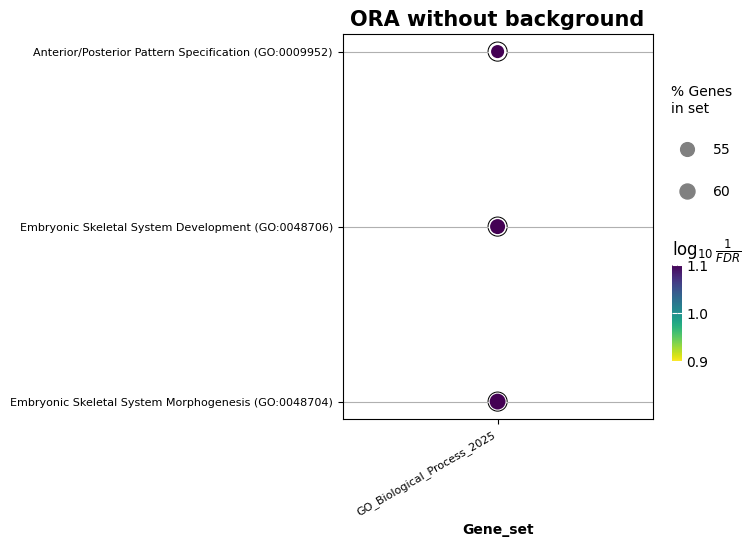

In [11]:
ax = gp.dotplot(enr.results, x='Gene_set', size=3, top_term=5, title='ORA without background', xticklabels_rot=30, show_ring=True, figsize=(5,5))
# use smaller fonts
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
ax.xaxis.label.set_size(10)
ax.title.set_size(15)

### ORA with background

By default, selected genes are tested against all genes available in the gene sets. For better results, it can be relevant to narrow it down to a list of genes of interest. 

Let's use the genes that were detected in our experiment as background genes, and see how it changes the result.

In [12]:
background_genes = list(set(gene_fc_sig_df.index))
print('Number of selected genes: ', len(deg))
print('Number of background genes: ', len(background_genes), '\n')

enr_bg = gp.enrichr(gene_list=deg, gene_sets=gene_sets, organism=organism, background=background_genes) 
# output top 5 results results 
enr_bg.results.sort_values('Adjusted P-value')[:5]

Number of selected genes:  5360
Number of background genes:  24221 



Gene_set  \
4460             KEGG_2021_Human   
0     GO_Biological_Process_2025   
4461             KEGG_2021_Human   
2     GO_Biological_Process_2025   
1     GO_Biological_Process_2025   

                                                   Term       P-value  \
4460            Neuroactive ligand-receptor interaction  2.909977e-09   
0     Anterior/Posterior Pattern Specification (GO:0...  2.683214e-10   
4461             Cytokine-cytokine receptor interaction  1.093437e-06   
2     Embryonic Skeletal System Morphogenesis (GO:00...  1.642854e-07   
1     Embryonic Skeletal System Development (GO:0048...  1.311706e-07   

      Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
4460      8.904529e-07            0                     0    2.199438   
0         1.196713e-06            0                     0    5.727161   
4461      1.672958e-04            0                     0    2.213999   
2         2.442377e-04            0                     0    6.740282   
1         2.442377e-04            0                     0    5.650975   

      Combined Score                                              Genes  
4460       43.230221  OXTR;NPFFR1;CHRM1;SCT;RXFP4;NR3C1;RXFP1;RXFP3;...  
0         126.219950  GATA4;PCSK5;HOXA9;TIFAB;SIX2;HOXA3;HOXC4;HOXA7...  
4461       30.389760  ACVRL1;CXCL6;CD40;IL25;TNFRSF13B;CSF1;EPO;IL27...  
2         105.294391  TBX1;TFAP2A;OSR2;OSR1;SIX1;TWIST1;SOX11;HOXD11...  
1          89.549675  DLX1;OSR2;DLX3;DLX4;SLC2A10;DLX6;OSR1;WNT5A;SI...

Visualize the top 5 terms for each gene set, with the default significance cutoff set at 0.05

  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))



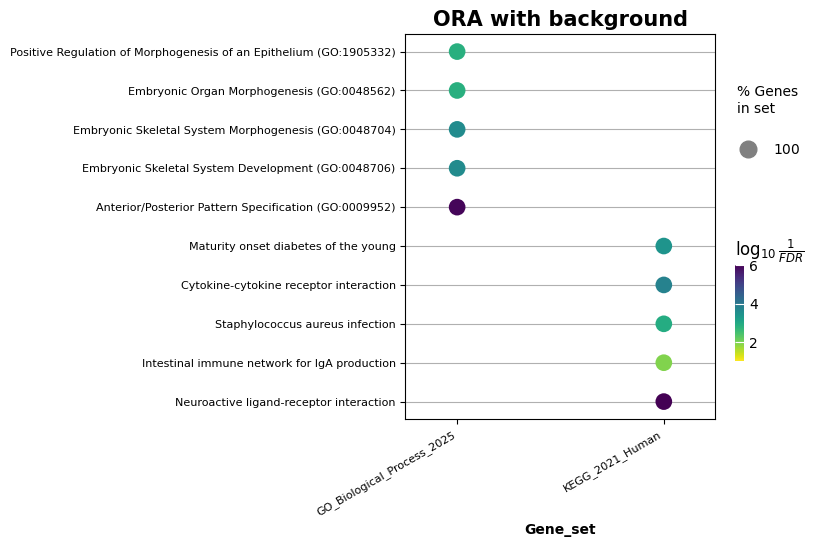

In [13]:
ax = gp.dotplot(enr_bg.results, x='Gene_set', size=2, top_term=5, figsize=(5, 5), y_order=True, title = 'ORA with background', xticklabels_rot=30)
# use smaller fonts
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
ax.xaxis.label.set_size(10)
ax.title.set_size(15)

In [14]:
del deg
del enr
del enr_bg

## Pre-rank GSEA

As we have already calculate DMPs an DMRs, we can use them to rank the genes and use the pre-rank method provided by gseapy. 

Here we use the formula `sign(FC) * - log10(significance)` to rank the genes, that bring the most upregulated genes at the beginning of the list, the most downregulated at the end, and the less differentialy expressed genes in the middle.

In [15]:
def rank_formula(row):
    if row[significance_colname] == 0: 
        return np.sign(row[fold_change_colname]) * np.inf
    return np.sign(row[fold_change_colname]) * -np.log10(row[significance_colname])

rank_data = gene_fc_sig_df.apply(rank_formula, axis=1).sort_values(ascending=False)

In [16]:
# we chose a low permutation number to speed up the demo
pre_res = gp.prerank(rnk=rank_data, gene_sets=gene_sets, verbose=True, permutation_num=1000, max_size=300, threads=4)

2025-09-22 14:37:42,522 [WARNING] Input gene rankings contains inf values!
  rankser.replace(-np.inf, method="ffill", inplace=True)

  rankser.replace(np.inf, method="bfill", inplace=True)

2025-09-22 14:37:42,525 [WARNING] Duplicated values found in preranked stats: 13.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-22 14:37:42,526 [INFO] Parsing data files for GSEA.............................
2025-09-22 14:37:42,543 [INFO] Enrichr library gene sets already downloaded in: /home/elio/.cache/gseapy, use local file
2025-09-22 14:37:42,564 [INFO] Enrichr library gene sets already downloaded in: /home/elio/.cache/gseapy, use local file
2025-09-22 14:37:42,596 [INFO] 3090 gene_sets have been filtered out when max_size=300 and min_size=15
2025-09-22 14:37:42,597 [INFO] 2573 gene_sets used for further statistical testing.....
2025-09-22 14:37:42,597 [INFO] Start to run GSEA...Might take a while..................
2025-09-22 14:38:44,447 [

Order the pathways by their False Discovery Rate (FDR), and show the ones that have a FDR lower than 0.05

In [17]:
pre_res.res2d = pre_res.res2d.sort_values('FDR q-val').reset_index(drop=True)
pre_res.res2d[pre_res.res2d['FDR q-val'] < 0.05]

Name                                               Term        ES  \
0  prerank  GO_Biological_Process_2025__Anterior/Posterior...  0.852806   
1  prerank  GO_Biological_Process_2025__Embryonic Skeletal...  0.860125   
2  prerank  GO_Biological_Process_2025__Mismatch Repair (G...  0.865357   
3  prerank  GO_Biological_Process_2025__Regulation of Gene... -0.915732   

        NES NOM p-val FDR q-val FWER p-val  Tag % Gene %  \
0  1.700103       0.0       0.0        0.0  29/55  7.51%   
1  1.671863       0.0  0.001502      0.003  21/32  7.09%   
2  1.617816       0.0  0.029382      0.075   1/24  0.33%   
3 -2.108197       0.0  0.033432      0.032   2/19  0.99%   

                                          Lead_genes  
0  HOXD3;HOXA3;HOXB3;WT1;HOXC4;HOXA9;HOXC6;GATA4;...  
1  HOXD3;HOXA3;HOXB3;HOXC4;HOXA9;COL2A1;HOXC9;SIX...  
2                                               TP73  
3                                      PRDM16;PRKAG2

Now we can visualize the most significant term

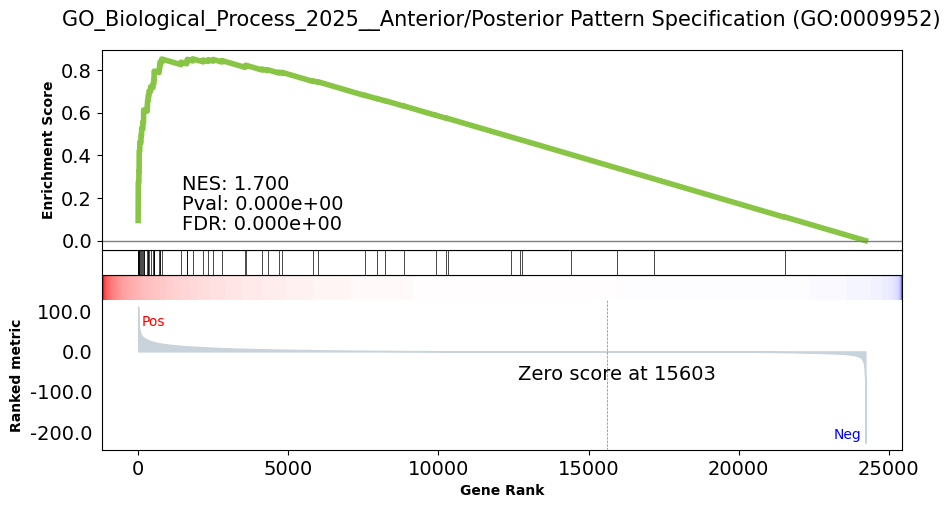

In [18]:
term = pre_res.res2d.Term[0]
fig = pre_res.plot(terms=term, figsize=(10, 5))
# use smaller fonts
for ax in fig.axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
_ = fig.suptitle(term, fontsize=15) 

Or visualize the top 5 terms on the same plot:

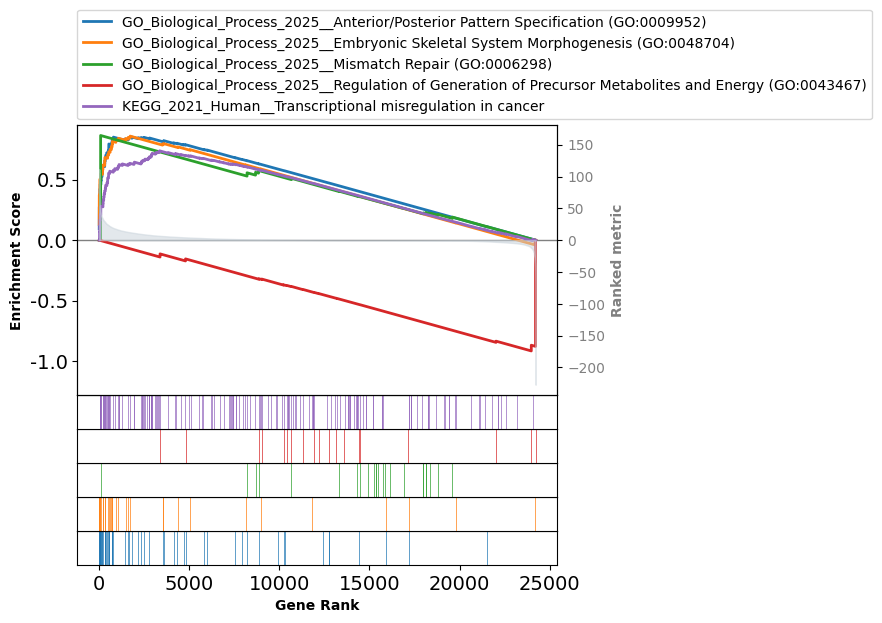

In [19]:
fig = pre_res.plot(terms=pre_res.res2d.Term[:5],figsize=(3,4))
# use smaller fonts
for ax in fig.axes:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)

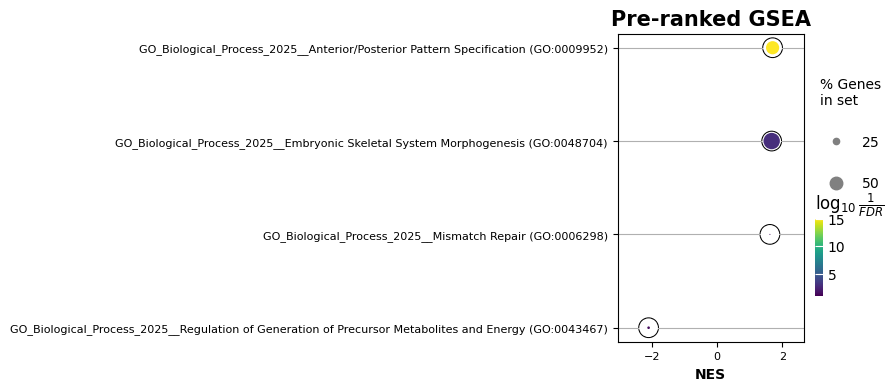

In [20]:
ax = gp.dotplot(pre_res.res2d, column='FDR q-val', title='Pre-ranked GSEA', cmap=plt.cm.viridis, size=3, figsize=(3, 4), show_ring=True)
# use smaller fonts
for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(8)
ax.xaxis.label.set_size(10)
ax.title.set_size(15)

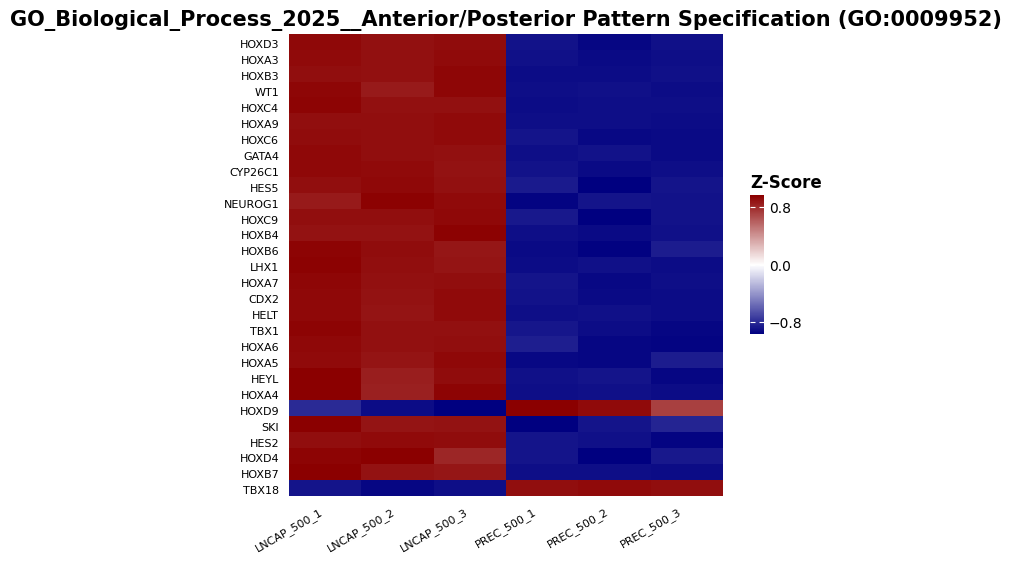

In [21]:
term_idx = 0  # chose the first term
genes = pre_res.res2d.Lead_genes[term_idx].split(";")
ax = gp.heatmap(df = genes_betas_df.loc[genes], z_score=0, title=pre_res.res2d.Term[term_idx], figsize=(7,6), yticklabels=False)
# use smaller fonts and show all labels
genes.reverse()  #for labels to be in the right order
ax.title.set_size(15)
_ = ax.set_xticks(range(len(genes_betas_df.columns)), labels=genes_betas_df.columns, rotation=30, ha="center",  fontsize=8)
_ = ax.set_yticks(range(len(genes)), labels=genes, va="bottom", fontsize=8)

Using pylluminator's function, we can go back to checking the beta values of the probes associated to a given gene

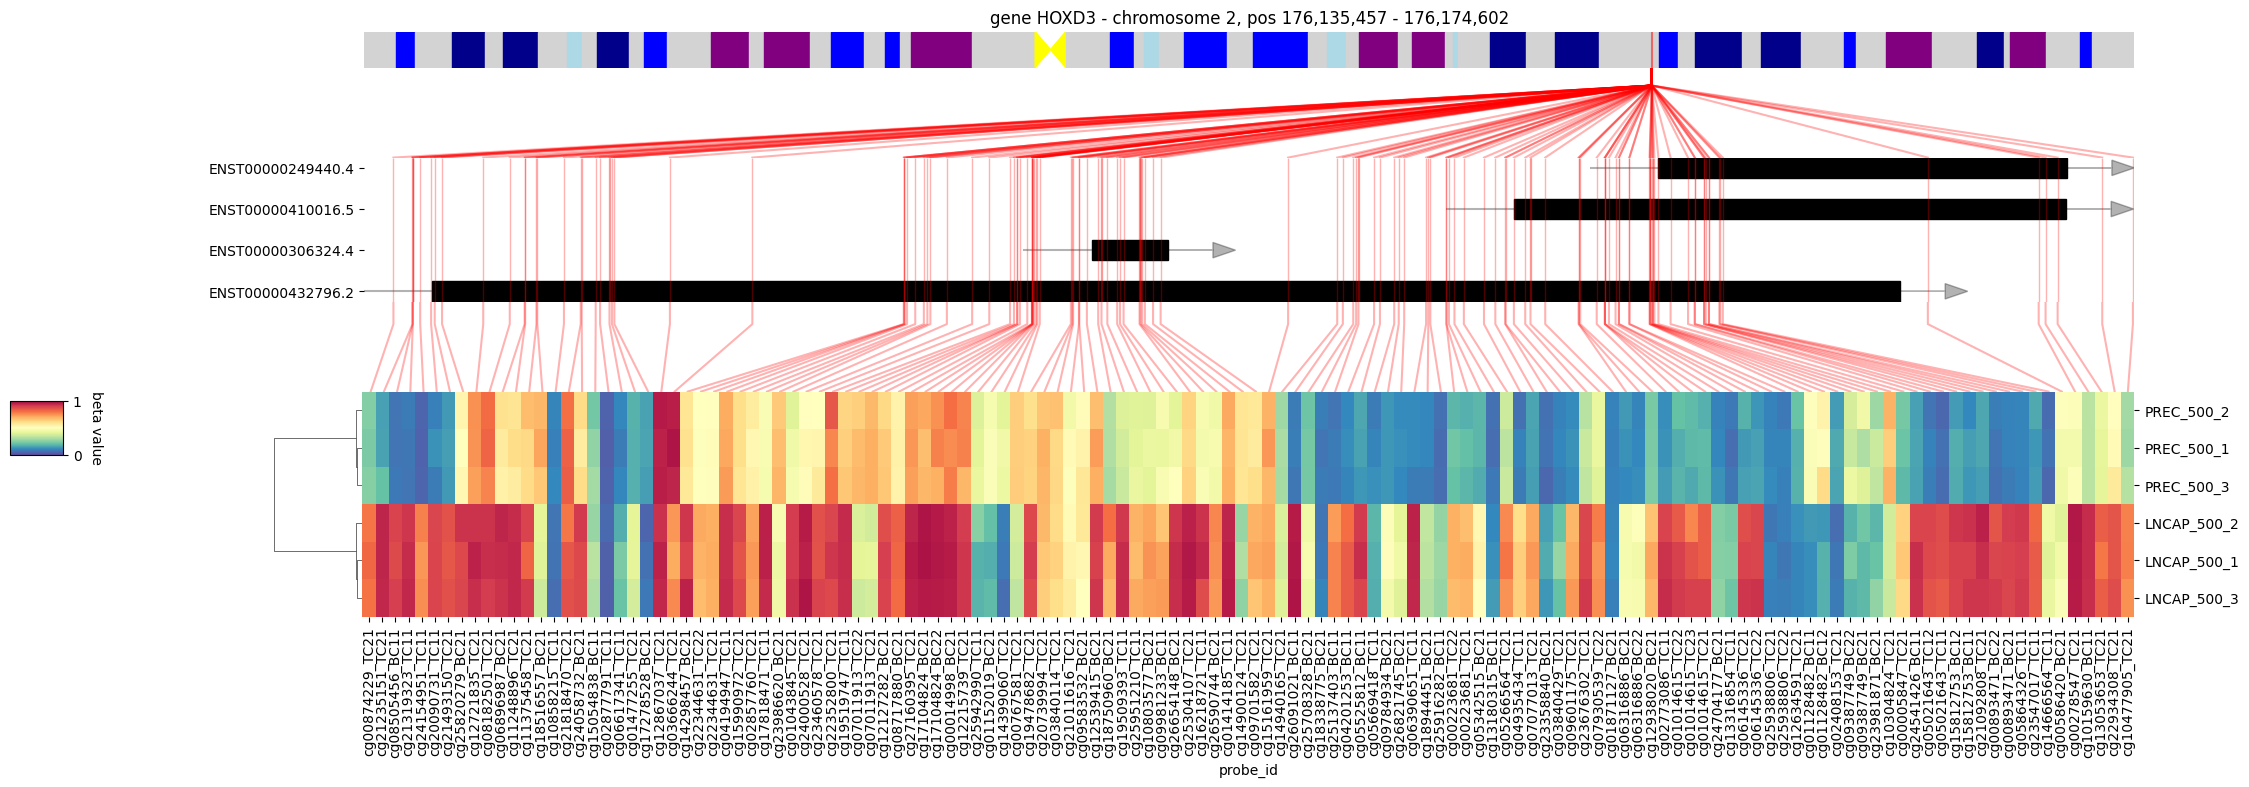

In [22]:
visualize_gene(my_dms.samples, 'HOXD3', figsize=(20, 6))

Finally, compute the enrichment map to show the relations between the detected relevant pathways

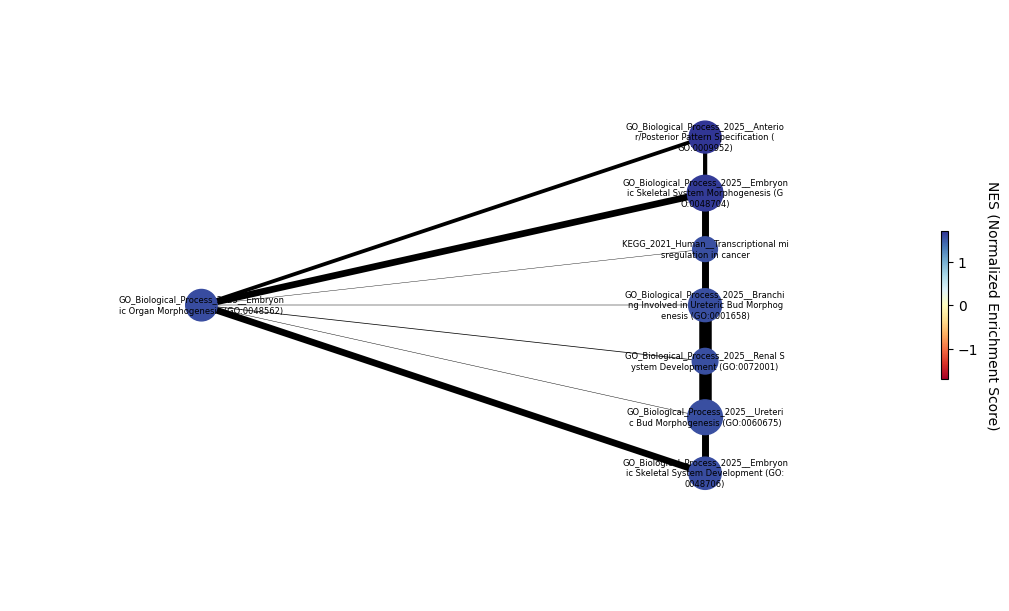

In [23]:
nodes, edges = gp.enrichment_map(pre_res.res2d, cutoff=0.1)  # chose a higher p-value cutoff to show more nodes, default is 0.05

# build graph
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

nodes = nodes.loc[G.nodes.keys()]  # remove nodes that are not connected by any edge

fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

# init node coordinates
pos=nx.layout.bfs_layout(G, start=nodes.index[0])

# add a colorbar
nodes_cmap = plt.cm.RdYlBu
max_NES = max(abs(min(nodes.NES)), max(nodes.NES))
sm = plt.cm.ScalarMappable(cmap=nodes_cmap, norm=plt.Normalize(vmin=-max_NES, vmax=max_NES))
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax, shrink=0.25)
cbar.set_label('NES (Normalized Enrichment Score)', rotation=270, labelpad=15)

# draw nodes
nx.draw_networkx_nodes(G, pos=pos,
                       cmap=nodes_cmap, node_color=nodes.NES, vmin=-max_NES, vmax=max_NES,
                       margins=0.3, node_size=list(nodes.Hits_ratio *1000))
# draw node labels - wrap labels so that they don't overlap
max_length = 35
wrapped_labels = {k: "\n".join([v[i:i+max_length] for i in range(0, len(v), max_length)]) for k, v in nodes.Term.to_dict().items()}
nx.draw_networkx_labels(G, pos=pos, font_size= 6, labels=wrapped_labels)

# draw edges
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G, pos=pos, width=list(map(lambda x: x*10, edge_weight)))

plt.axis('off')
plt.show()


In [24]:
del gene_fc_sig_df
del pre_res
del my_dms

## GSEA

Since we are working with two groups (healthy control cells and prostate cancer cells), we can directly use the GSEA function on our 'raw' data (here, the genes beta values) with the corresponding phenotype dataframe (sample_types), to find the enriched pathways. Uncomment the following code to run the analysis.

In [25]:
# gs = gp.GSEA(data=genes_betas_df.dropna(), gene_sets=gene_sets, classes=sample_types, permutation_num=1000)  
# gs.pheno_neg = 'PREC'  # control samples
# gs.pheno_pos = 'LNCAP'  # samples of prostate cancer cells
# gs.run()

Visualize the top 5 identified pathways

In [26]:
# _ = gs.plot(gs.res2d.Term[:5])

Visualize, for a given pathway and for each gene, the samples z-score.

In [27]:
# term_idx = 0  # chose the first term
# genes = gs.res2d.Lead_genes[term_idx].split(";")
# ax = gp.heatmap(df = genes_betas_df.loc[genes], z_score=0, title=gs.res2d.Term[term_idx], figsize=(8,4))